# Chat bot question answering.

The goal of your project is to create a chatbot model that provides answers on client questions.   
Your goal is to divide your dataset on several sections and to make multi-level classifier that will classify the section and later the most reasonable(closest) answer.    
Take care about text-preprocessing, stop words removal, and sentence vectorization

This project consists of the following activities :  




1. Phase 1 : Dataset
    * Team Planning
    * Full git project Integration
    * General Project Research
    * Dataset Collection
    * Dataset Preparation
2. Phase 2 : Training
    * Research about NLP model
    * Compose NLP model
        * Stop words Removal
        * Text tokenization
        * Text Preprocessing
        * Question vectorization
        * Find closest vector
    * Ping Pong phase with Dataset labelers
    * Generate more data if needed
    * Fine tunning of your model


3. Phase 3 : Deployment
    * Perform manual benchmark
    * Model Deploy (Git)
    * Write git Readme.md file
    * Receive Feedback from PM


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
import re
import string
from scipy.spatial.distance import cdist
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import precision_recall_fscore_support as score

from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout, Activation
from keras.layers.embeddings import Embedding
from keras.preprocessing import sequence
from keras.preprocessing.text import Tokenizer
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.utils import to_categorical

from sklearn.metrics import ConfusionMatrixDisplay, plot_confusion_matrix, classification_report, confusion_matrix


from bpemb import BPEmb
import xgboost as xgb

%matplotlib inline

Using TensorFlow backend.


# Load Data

In [2]:
brainster_df = pd.read_csv('dataset/dataset_brainster.csv')

In [3]:
brainster_df

,questions,answers,category,category_id
0,Колку време трае академијата за дигитален марк...,Академијата за дигитален маркетинг трае 23 нед...,маркетинг,1
1,Колку трае академијата за дигитален маркетинг?,Академијата за дигитален маркетинг трае 23 нед...,маркетинг,1
2,колку месеци недели е академијата за дигитален...,Академијата за дигитален маркетинг трае 23 нед...,маркетинг,1
3,колку недели е академијата за дигитален маркетинг,Академијата за дигитален маркетинг трае 23 нед...,маркетинг,1
4,колку месеци е академијата за дигитален маркетинг,Академијата за дигитален маркетинг трае 23 нед...,маркетинг,1
...,...,...,...,...
3175,Дали на академијата за UX/UI има практична раб...,На Академијата се работи на практични проекти ...,UX/UI,7
3176,какви проекти се работат на UX/UI,На Академијата се работи на практични проекти ...,UX/UI,7
3177,Дали на крајот на Академијата за UX/UI се доби...,"Да, работата на Академијата за UX/UI ја оценув...",UX/UI,7
3178,Дали има оценување на Академијата за UX/UI?,"Да, работата на Академијата за UX/UI ја оценув...",UX/UI,7


# Provide and prepare data information

In [4]:
questions = brainster_df.questions
other_col = brainster_df.drop(columns='questions', axis=0)

In [5]:
print(questions.shape, other_col.shape)

(3180,) (3180, 3)


In [6]:
other_col.head(5)

,answers,category,category_id
0,Академијата за дигитален маркетинг трае 23 нед...,маркетинг,1
1,Академијата за дигитален маркетинг трае 23 нед...,маркетинг,1
2,Академијата за дигитален маркетинг трае 23 нед...,маркетинг,1
3,Академијата за дигитален маркетинг трае 23 нед...,маркетинг,1
4,Академијата за дигитален маркетинг трае 23 нед...,маркетинг,1


In [7]:
questions.head(5)

0    Колку време трае академијата за дигитален марк...
1       Колку трае академијата за дигитален маркетинг?
2    колку месеци недели е академијата за дигитален...
3    колку недели е академијата за дигитален маркетинг
4    колку месеци е академијата за дигитален маркетинг
Name: questions, dtype: object

In [8]:
questions_array = questions.to_numpy()
questions_array

array(['Колку време трае академијата за дигитален маркетинг?',
       'Колку трае академијата за дигитален маркетинг?',
       'колку месеци недели е академијата за дигитален маркетинг', ...,
       'Дали на крајот на Академијата за UX/UI се добива оценка?',
       'Дали има оценување на Академијата за UX/UI?',
       'Дали работата на академијата за UX/UI се оценува?'], dtype=object)

# Data Preprocessing

In [9]:
lat_to_cyr = {'kj' : 'ќ', 'gj' : 'ѓ', 'zh' : 'ж', 'ch' : 'ч', 'sh' : 'ш', 'dj' : 'ѓ',
              'a' : 'а', 'b' : 'б', 'c' : 'ц', 'd' : 'д', 'e' : 'е', 'f' : 'ф', 'g' : 'г',
              'h' : 'х', 'i' : 'и', 'j' : 'ј', 'k' : 'к', 'l' : 'л', 'm' : 'м', 'n' : 'н',
              'o' : 'о', 'p' : 'п', 'q' : 'љ', 'r' : 'р', 's' : 'с', 't' : 'т', 'u' : 'у',
              'v' : 'в', 'w' : 'њ', 'x' : 'џ', 'y' : 'ѕ', 'z' : 'з'
             }

In [10]:
stop_words_mkd = pd.read_csv('stop_words.txt').to_numpy()
stop_words_list = []
for words in stop_words_mkd:
    for word in words:
        stop_words_list.append(word)
        
len(stop_words_list)

192

In [11]:
# input (text) must be array

def text_preprocessed(text, stop_words):
    remove_punctuation = []
    for questions in text:
        lower_case = questions.lower()
        string_punct = str(lower_case).translate(str.maketrans('', '', string.punctuation))
        tokenization = nltk.word_tokenize(string_punct)
        stop_words_removed = []
        for token in tokenization:
            if token not in stop_words:
                stop_words_removed.append(token)
        final = ' '.join(stop_words_removed)
        remove_punctuation.append(final)
    
    questions = []
    for question in remove_punctuation:
        for key, value in lat_to_cyr.items():
            question = re.sub(key, value, question.lower())
        questions.append(question)
    return questions

In [12]:
questions_translated = text_preprocessed(questions_array, stop_words_list)

In [13]:
questions_translated[1:7]

['колку трае академијата дигитален маркетинг',
 'колку месеци недели академијата дигитален маркетинг',
 'колку недели академијата дигитален маркетинг',
 'колку месеци академијата дигитален маркетинг',
 'колку долго трае академијата маркетинг',
 'како наставата академијата дигитален маркетинг']

In [14]:
questions_array[5]

'Колку долго трае академијата за маркетинг?'

# Define Model Architecture

# Count Vectorizer Model

In [15]:
count_vector_model = CountVectorizer(stop_words=stop_words_list, strip_accents='unicode')

In [16]:
count_vector_features = count_vector_model.fit_transform(questions_translated)
questions_df = pd.DataFrame(data = count_vector_features.todense(), 
                            columns=count_vector_model.get_feature_names())

questions_df.tail(10)

C:\Users\Gj\Anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:385: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ве', 'веке', 'ке', 'повеке', 'сe'] not in stop_words.
  'stop_words.' % sorted(inconsistent))


,15,1630,24,автоматско,адс,акадеимјата,академии,академиите,академија,академијата,...,јадеш,јазик,јазици,јак,јупѕтер,јљуерѕ,ља,њарехоусе,њебдривер,њебсите
3170,0,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
3171,0,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
3172,0,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
3173,0,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
3174,0,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
3175,0,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
3176,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3177,0,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
3178,0,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
3179,0,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0


In [17]:
questions_df.shape

(3180, 773)

In [18]:
# display function

def display_all(df):
    with pd.option_context("display.max_rows", 1000, "display.max_columns", 1000): 
        display(df)

In [19]:
display_all(questions_df.head(1))

,15,1630,24,автоматско,адс,акадеимјата,академии,академиите,академија,академијата,академијта,акадмијата,акредитација,акредитиран,акредитирана,активности,алгоритми,анализа,ангажирани,англиски,аплицира,аплицираат,аплицирам,аплицирање,аппиум,арогантен,асистирате,атрактивна,аутоматед,ајаџ,бази,банкарски,басес,басицс,бацкенд,библиотека,биг,бидам,бидат,бирате,боотстрап,боја,браинстер,брака,број,бусинесс,важи,ваучер,ваучери,ваучерот,ваш,ваша,ве,веб,вебсајт,вечер,видам,видат,видеа,видеата,видео,види,викенд,вирусот,вклучам,вклучува,владата,внимание,возбуден,возраст,вработување,време,времетрање,врска,врши,вршите,генератион,гит,години,гоогле,готово,граница,графички,гроут,гроњтх,група,групата,групи,гугл,давате,дадете,дале,дали,дата,датабази,датабасес,датум,датумрок,дај,дебар,дебитна,дееп,дел,делот,ден,денови,деновиве,денот,детали,детална,детално,дигитал,дигитален,дигиталниот,дизајн,дизајни,дизајните,диплома,дипломата,добар,добив,добива,добивам,добивање,добиен,добијам,добра,додатни,доделува,доделувате,дозволите,документ,долго,дополнителни,достапна,достапни,држат,економски,електро,емоции,женет,живеам,живееш,живо,завршен,завршување,завршувањето,заглавам,заинтересиран,заинтересирана,запишам,запишеме,запишуваат,запишување,започнам,започната,започнеме,започнува,зашто,здраво,земам,земјава,земјата,знаел,знаење,знам,зошто,идејно,избираат,избирате,изведуваат,изработам,изработка,изработуваат,изучува,изучуваат,изучувате,имаат,имаме,имаш,инстаграм,инсталирам,инсталирање,инструктори,инструкторите,интеллигенце,интереси,интересира,инфо,информации,информација,исконтактирам,искористи,искусни,искуство,исполнувам,ит,каде,кажете,кажи,каква,какви,какво,како,каков,камата,камера,канал,кандидати,кандидатите,канцелариите,кариерен,картичка,кај,керас,клиенти,книга,книги,кога,кого,кое,кои,колкав,колкава,колкави,колку,компании,компетентен,компјутер,компјутери,компјутерот,конзумираш,конкретно,контакт,контактирам,контент,концепирана,копирајтинг,користам,користат,користи,користите,корона,короната,кошта,кој,која,кратки,кратко,крај,крајниот,крајот,кредит,кредитна,креирање,купам,купи,курс,курсеви,курсевите,лаптоп,лаптопот,ларавел,лаѕоут,леад,леарн,леарнинг,лето,лејаут,линкдин,линкедин,листа,литература,лица,лого,локациски,локација,локацијата,луге,маало,мавен,маил,макдеонски,македонија,македонски,маркетинг,математика,мачине,машински,машинско,мајка,мегународно,ментори,месеци,места,место,минати,мининг,мк,млади,мое,можеш,можностите,мокен,моменталната,мој,мразиш,мрежи,муабет,надвор,намаление,намалување,наменет,наменета,наогаат,наогате,направам,направен,направи,напреден,напредна,напредни,напредувал,населба,насочам,настава,наставата,науки,начин,начини,наши,најважно,најдам,најдобро,најмалку,најмногу,невронски,недели,неделно,немам,неопходно,нетњоркс,неурал,ниво,нлп,нов,новите,нок,нуди,нудите,обврски,област,областа,области,обработуваат,обука,обуката,објектно,овозможувате,огранизирате,одбивте,одбиен,одбираат,одбирате,одговор,одговоривте,одлука,одлучам,однос,односно,одржува,одржуваат,озборуваш,омилен,омилена,омилени,онлајн,онлине,онлинепреку,ооп,опрема,опфака,опфатен,опфатот,опција,општествени,организира,организирате,организирање,ориентирано,останати,оф,официјалните,оценка,оценува,оценување,пазарот,пакување,пари,партиципирам,партнер,партнери,пат,пати,пајтон,перспективи,перформанси,плака,плакам,плакање,плакањето,план,планира,планирате,платам,плати,плашиш,пллатам,побарам,податоци,подговотвка,подготвам,подготвителна,подготвителната,подготовка,подготовки,поддржите,поддршка,подобра,подразбира,подразбора,подротвителна,позадина,поздрав,познавања,познавање,полна,помагате,помегу,помогне,помогнете,помош,пополнета,попоуст,попуп,попуст,поразговарам,поразговарм,поректите,портфолио,посветува,поседувам,посета,посредувате,посредување,постер,потребен,потребна,потребни,потребно,почетник,почетници,почетокот,почнала,почнам,почне,почнува,почнуваат,почнувате,појаснување,поњерби,правам,прават,правата,правен,правење,правиме,правите,пракса,практична,практични,практично,пратете,прашам,прашања,прашувам,прегледам,п

# TF-IDF

In [20]:
tf_idf_model = TfidfVectorizer(stop_words=stop_words_list, strip_accents='unicode')

In [21]:
tf_idf_features = tf_idf_model.fit_transform(questions_translated)
questions_df_tfidf = pd.DataFrame(data = tf_idf_features.todense(), 
                            columns=tf_idf_model.get_feature_names())

questions_df_tfidf.tail(10)

C:\Users\Gj\Anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:385: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ве', 'веке', 'ке', 'повеке', 'сe'] not in stop_words.
  'stop_words.' % sorted(inconsistent))


,15,1630,24,автоматско,адс,акадеимјата,академии,академиите,академија,академијата,...,јадеш,јазик,јазици,јак,јупѕтер,јљуерѕ,ља,њарехоусе,њебдривер,њебсите
3170,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.168151,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3171,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.150914,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3172,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.119015,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3173,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.134843,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3174,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.127214,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3175,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.146249,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3176,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3177,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.134807,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3178,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.196365,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3179,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.153650,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


# TfidfVectorizer Ngrams

In [22]:
tf_idf_ngram_model = TfidfVectorizer(ngram_range=(1,2), stop_words=stop_words_list, strip_accents='unicode')

In [23]:
tf_idf_ngram_features = tf_idf_ngram_model.fit_transform(questions_translated)

questions_df_tfidf_ngram = pd.DataFrame(data = tf_idf_ngram_features.todense(), 
                            columns=tf_idf_ngram_model.get_feature_names())

questions_df_tfidf_ngram.tail(10)

C:\Users\Gj\Anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:385: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ве', 'веке', 'ке', 'повеке', 'сe'] not in stop_words.
  'stop_words.' % sorted(inconsistent))


,15,15 рати,1630,1630 конкретно,24,24 рати,автоматско,автоматско тестирање,адс,акадеимјата,...,ља работат,ља работи,ља следам,ља стекнува,ља странство,ља училница,њарехоусе,њарехоусе академијата,њебдривер,њебсите
3170,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3171,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3172,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3173,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3174,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3175,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3176,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3177,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3178,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3179,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


# Test Part

In [24]:
client = text_preprocessed(["колку трае академијата за дигитален маркетинг"], stop_words_list)

In [25]:
client

['колку трае академијата дигитален маркетинг']

CountVectorizer

In [26]:
client_count_feature = count_vector_model.transform(client)

TfIdfVectorizer

In [27]:
client_tfidf_feature = tf_idf_model.transform(client)

TfIdfVectorizer Ngram

In [28]:
client_tfidf_ngram_feature = tf_idf_ngram_model.transform(client)

# Define distance between two vectors

In [29]:
def distance_vectors(answer, features, client_feature):
    cosine_function = lambda a, b : round(np.inner(a, b)/(np.linalg.norm(a)*np.linalg.norm(b)), 3)
    distances = []
    for vector in features.toarray():
        for clietn_vector in client_feature.toarray():
            cosine = cosine_function(vector, clietn_vector)
            distances.append(cosine)
    index = np.argmax(distances)
    max_cosine = max(distances)
    return answer.answers[index], index, max_cosine   

# Example :  
   Find the closest dataset question based on user defined question

In [30]:
client

['колку трае академијата дигитален маркетинг']

In [31]:
cv_answer, cv_index, cv_cosine = distance_vectors(other_col, count_vector_features, client_count_feature)

In [32]:
print("Most equal answer :", cv_answer)
print('Raw number', cv_index)
print('Cosine coefficient:', cv_cosine)

Most equal answer : Академијата за дигитален маркетинг трае 23 недели.
Raw number 1
Cosine coefficient: 1.0


In [33]:
tfidf_answer, tfidf_index, tfidf_cosine = distance_vectors(other_col, tf_idf_features, client_tfidf_feature)

In [34]:
print("Most equal answer :", tfidf_answer)
print('Raw number', tfidf_index)
print('Cosine coefficient:', tfidf_cosine)

Most equal answer : Академијата за дигитален маркетинг трае 23 недели.
Raw number 1
Cosine coefficient: 1.0


In [35]:
ngram_answer, ngram_index, ngram_cosine = distance_vectors(other_col, tf_idf_ngram_features, client_tfidf_ngram_feature)

In [36]:
print("Most equal answer :", ngram_answer)
print('Raw number', ngram_index)
print('Cosine coefficient:', ngram_cosine)

Most equal answer : Академијата за дигитален маркетинг трае 23 недели.
Raw number 1
Cosine coefficient: 1.0


# Word Embbeding

In [37]:
bpemb_mk = BPEmb(lang="mk", dim=300)

In [38]:
questions_translated[1:5]

['колку трае академијата дигитален маркетинг',
 'колку месеци недели академијата дигитален маркетинг',
 'колку недели академијата дигитален маркетинг',
 'колку месеци академијата дигитален маркетинг']

In [39]:
#cos_sim = np.argmax(cosine_similarity([vector],embed_questions))

In [40]:
def result_embed(questions, clinet_question, stop_words):
# embeding of question from dataset
    embed_questions = []
    for question in questions:
        embed_questions.append(bpemb_mk.embed(question).mean(axis=0))

# preproccess and ebmeding of client question
    prepared_question = text_preprocessed([clinet_question], stop_words)

    for query in [prepared_question]:
        query_embedding = bpemb_mk.embed(query).mean(axis=0)
        
        # cdist give us how much is the error similarity
        distances = cdist([query_embedding], embed_questions, "cosine")[0]

        results = zip(range(len(distances)), distances)
        results = sorted(results, key=lambda x: x[1])
        
        print("Прашање:", query)
        print("\n======================\n")
        print("\nTop 5 најдобри резултати:\n")

        for idx, distance in results[0:10]:
            print(other_col.answers[idx].strip(),'\n', "(Score: %.4f)" % (1-distance),'\n', "Index: ", idx)
    

In [41]:
result_embed(questions_translated, 'dali rabotite vo pythorch', stop_words_list)

Прашање: ['дали работите во пѕтхорч']



Top 5 најдобри резултати:

Невронски мрежи е предвидено да се работат во Keras 
 (Score: 0.7620) 
 Index:  1815
Невронски мрежи е предвидено да се работат во Keras 
 (Score: 0.7166) 
 Index:  1811
Невронски мрежи е предвидено да се работат во Keras 
 (Score: 0.7064) 
 Index:  1817
Невронски мрежи е предвидено да се работат во Keras 
 (Score: 0.6808) 
 Index:  1816
Невронски мрежи е предвидено да се работат во Keras 
 (Score: 0.6674) 
 Index:  2053
Би сакале да Ве информираме дака посебна акдемија за Python немаме, меѓутоа Python се изучува во рамки на академијата за Data Science. 
 (Score: 0.5484) 
 Index:  1886
Предавањата за PHP се во склоп на академијата за full-stack програмирање 
 (Score: 0.5399) 
 Index:  1337
Да, на академијата за Data science се изучувa Python 
 (Score: 0.5009) 
 Index:  1770
Невронски мрежи е предвидено да се работат во Keras 
 (Score: 0.4949) 
 Index:  1824
Да, на академијата за Data science се изучувa Python 
 (Score:

C:\Users\Gj\Anaconda3\lib\site-packages\bpemb\bpemb.py:383: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return self.emb.vectors[ids]


# Classification Model

In [42]:
def dataset_preprocess(X_part, labels):
    embed_questions = []
    for question in X_part:
        embed_questions.append(bpemb_mk.embed(question).mean(axis=0))
    questions_embed = np.array(embed_questions)    
    target = to_categorical(labels)
    
    X_train, X_test, y_train, y_test = train_test_split(questions_embed, target, test_size=0.20, random_state=10)
    
    return X_train, X_test, y_train, y_test
    

In [43]:
questions_translated[0:5]

['колку време трае академијата дигитален маркетинг',
 'колку трае академијата дигитален маркетинг',
 'колку месеци недели академијата дигитален маркетинг',
 'колку недели академијата дигитален маркетинг',
 'колку месеци академијата дигитален маркетинг']

In [44]:
X_train, X_test, y_train, y_test = dataset_preprocess(questions_translated, other_col.category_id)

In [45]:
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(2544, 300) (636, 300) (2544, 8) (636, 8)


In [47]:
model = Sequential()

model.add(Dense(256, input_dim=300))
model.add(Activation('relu'))

model.add(Dense(128))
model.add(Activation('relu'))

model.add(Dense(64))
model.add(Activation('relu'))

model.add(Dense(32))
model.add(Activation('relu'))

model.add(Dense(16))
model.add(Activation('relu'))

model.add(Dense(10))
model.add(Activation('relu'))

model.add(Dense(8))
model.add(Activation('softmax'))

print(model.summary())

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 256)               77056     
_________________________________________________________________
activation_1 (Activation)    (None, 256)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 128)               32896     
_________________________________________________________________
activation_2 (Activation)    (None, 128)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 64)                8256      
_________________________________________________________________
activation_3 (Activation)    (None, 64)                0         
_________________________________________________________________
dense_4 (Dense)              (None, 32)               

In [72]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [73]:
my_callback1 = ModelCheckpoint('best_model.pt', verbose=1, save_best_only=True, mode='max', monitor='val_accuracy')
#my_callback2 = EarlyStopping(patience=7)

my_callbacks = [my_callback1]

In [74]:
model.fit(X_train, y_train, batch_size=None,
    epochs=50,
    verbose=1,
    callbacks=my_callbacks,
    validation_split=0.0,
    validation_data=(X_test, y_test),
    shuffle=True,
    class_weight=None,
    sample_weight=None,
    initial_epoch=0,
    steps_per_epoch=None,
    validation_steps=None,
    validation_freq=1,
    max_queue_size=10,
    workers=1)

Train on 2544 samples, validate on 636 samples
Epoch 1/50
2544/2544 [==============================] - 1s 479us/step - loss: 0.0140 - accuracy: 0.9988 - val_loss: 0.3139 - val_accuracy: 0.9843

Epoch 00001: val_accuracy improved from -inf to 0.98428, saving model to best_model.pt
Epoch 2/50
2544/2544 [==============================] - 1s 293us/step - loss: 0.0164 - accuracy: 0.9953 - val_loss: 0.1721 - val_accuracy: 0.9874

Epoch 00002: val_accuracy improved from 0.98428 to 0.98742, saving model to best_model.pt
Epoch 3/50
2544/2544 [==============================] - 1s 296us/step - loss: 0.0201 - accuracy: 0.9949 - val_loss: 0.1755 - val_accuracy: 0.9858

Epoch 00003: val_accuracy did not improve from 0.98742
Epoch 4/50
2544/2544 [==============================] - 1s 256us/step - loss: 0.0091 - accuracy: 0.9988 - val_loss: 0.1555 - val_accuracy: 0.9890

Epoch 00004: val_accuracy improved from 0.98742 to 0.98899, saving model to best_model.pt
Epoch 5/50
2544/2544 [=====================

2544/2544 [==============================] - 1s 267us/step - loss: 2.3586e-06 - accuracy: 1.0000 - val_loss: 0.2211 - val_accuracy: 0.9921

Epoch 00039: val_accuracy did not improve from 0.99214
Epoch 40/50
2544/2544 [==============================] - 1s 257us/step - loss: 2.2266e-06 - accuracy: 1.0000 - val_loss: 0.2219 - val_accuracy: 0.9921

Epoch 00040: val_accuracy did not improve from 0.99214
Epoch 41/50
2544/2544 [==============================] - 1s 259us/step - loss: 2.1016e-06 - accuracy: 1.0000 - val_loss: 0.2227 - val_accuracy: 0.9921

Epoch 00041: val_accuracy did not improve from 0.99214
Epoch 42/50
2544/2544 [==============================] - 1s 250us/step - loss: 1.9891e-06 - accuracy: 1.0000 - val_loss: 0.2234 - val_accuracy: 0.9921

Epoch 00042: val_accuracy did not improve from 0.99214
Epoch 43/50
2544/2544 [==============================] - 1s 263us/step - loss: 1.8813e-06 - accuracy: 1.0000 - val_loss: 0.2242 - val_accuracy: 0.9921

Epoch 00043: val_accuracy did no

In [75]:
model.load_weights('best_model.pt')

In [76]:
predict_question = model.predict(X_test)

In [77]:
# Final evaluation of the model
scores = model.evaluate(X_test, y_test, verbose = 1, callbacks=my_callbacks)
print("Accuracy relu activation: %.2f%%\n" % (scores[1]*100))

636/636 [==============================] - 0s 101us/step
Accuracy relu activation: 99.21%



In [78]:
#Convert predictions to 0/1 vectors
y_pred_relu = np.array([int(np.argmax(predict_question[i])) for i in range(len(predict_question))])
y_test_array = [np.argmax(y_test[i]) for i in range(len(y_test))]

relu_accuracy = (y_pred_relu == y_test_array).mean()

In [79]:
precision, recall, relu_fscore, support = score(y_test_array, y_pred_relu, average='macro')
print(np.round(relu_accuracy, 3), np.round(relu_fscore, 3))


0.992 0.993


Classification Report: relu 
               precision    recall  f1-score   support

           0       0.94      1.00      0.97        68
           1       1.00      0.99      0.99        71
           2       1.00      1.00      1.00        42
           3       1.00      1.00      1.00        79
           4       0.99      0.97      0.98       120
           5       1.00      1.00      1.00        95
           6       1.00      0.99      1.00       127
           7       1.00      1.00      1.00        34

    accuracy                           0.99       636
   macro avg       0.99      0.99      0.99       636
weighted avg       0.99      0.99      0.99       636



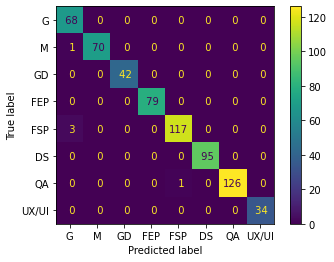

In [80]:
labels = ['G', 'M', 'GD', 'FEP', 'FSP', 'DS', 'QA', 'UX/UI']

cr_we_relu = classification_report(y_test_array, y_pred_relu)
print('Classification Report: relu \n', cr_we_relu)
disp = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(y_test_array, y_pred_relu),
                              display_labels=labels, )

disp = disp.plot(values_format='3')

plt.show()

In [81]:
def class_predict(client_question, stop_words):
    client_question_embed = bpemb_mk.embed(text_preprocessed([client_question], stop_words)).mean(axis=0)
    question_reshape = client_question_embed.reshape(1, 300)
    class_predict = np.argmax(model.predict(question_reshape))
    print(labels[class_predict])

In [82]:
class_predict('dali uchite keras vo data science', stop_words_list)

DS


C:\Users\Gj\Anaconda3\lib\site-packages\bpemb\bpemb.py:383: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return self.emb.vectors[ids]


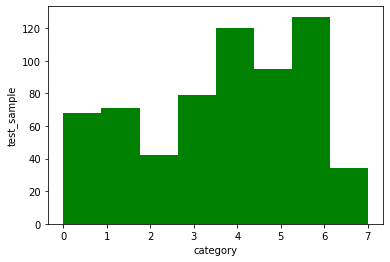

In [83]:
plt.hist(y_test_array, bins=8, color='g' )  
plt.ylabel('test_sample')
plt.xlabel('category')
plt.show()

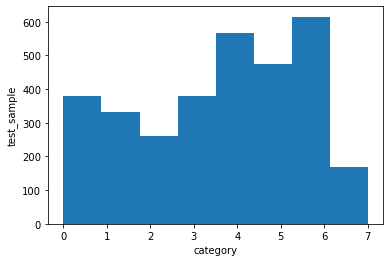

In [84]:
fig, ax = plt.subplots()
ax.hist(other_col.category_id, bins=8)  
plt.ylabel('test_sample')
plt.xlabel('category')
#for tick in ax.get_xticklabels():
#    tick.set_rotation(90)
plt.show()

In [85]:
y_train_array = [np.argmax(y_train[i]) for i in range(len(y_train))]

In [86]:
xgb_classifier = xgb.XGBClassifier()

xgb_classifier.fit(X_train, y_train_array)



XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=0, num_parallel_tree=1,
              objective='multi:softprob', random_state=0, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=None, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

              precision    recall  f1-score   support

           0       0.92      0.96      0.94        68
           1       0.96      0.99      0.97        71
           2       1.00      1.00      1.00        42
           3       1.00      1.00      1.00        79
           4       0.98      0.97      0.97       120
           5       1.00      1.00      1.00        95
           6       1.00      0.97      0.98       127
           7       0.97      1.00      0.99        34

    accuracy                           0.98       636
   macro avg       0.98      0.98      0.98       636
weighted avg       0.98      0.98      0.98       636



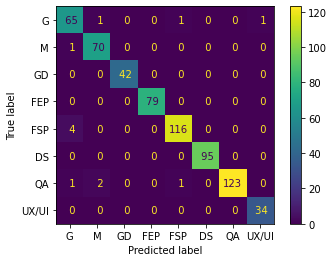

In [87]:
xgb_pred = xgb_classifier.predict(X_test)

#Printing the classification report
xgb_class_report = classification_report(y_test_array, xgb_pred)
print(xgb_class_report)

#confusion_matrix()
disp = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(y_test_array, xgb_pred),
                              display_labels=labels)

disp = disp.plot(values_format='3')

plt.show()

In [88]:
def class_predict_xgb(client_question, stop_words):
    q_tr = text_preprocessed([client_question], stop_words)
    client_question_embed = bpemb_mk.embed(q_tr).mean(axis=0)
    question_reshape = client_question_embed.reshape(1, 300)
    class_predict = np.argmax(xgb_classifier.predict(question_reshape))
    print(labels[class_predict])

In [89]:
class_predict_xgb('shto se uchi na akademijata za data science', stop_words_list)

G


In [90]:
prasanje = 'што се учи на академијата за дизајн'

In [91]:
class_predict(prasanje, stop_words_list)

GD


In [92]:
result_embed(questions_translated, prasanje, stop_words_list)

Прашање: ['што учи академијата дизајн']



Top 5 најдобри резултати:

На Академијата за графички дизајн предвидено е изучување на дизајн и типографија, работа со соодветен софтвер (Illustrator, Photoshop, Indesign). Знаењето практично се применува на проекти (на пр. дизајн на лого, постер, пакување). 
 (Score: 0.8393) 
 Index:  391
Во Академијата за графички дизајн ќе работите со софтверските пакети Adobe Illustrator, Adobe Photoshop и Adobe Indesign. 
 (Score: 0.7478) 
 Index:  384
На Академијата за графички дизајн предвидено е изучување на дизајн и типографија, работа со соодветен софтвер (Illustrator, Photoshop, Indesign). Знаењето практично се применува на проекти (на пр. дизајн на лого, постер, пакување). 
 (Score: 0.7165) 
 Index:  386
На Академијата за графички дизајн предвидено е изучување на дизајн и типографија, работа со соодветен софтвер (Illustrator, Photoshop, Indesign). Знаењето практично се применува на проекти (на пр. дизајн на лого, постер, пакување). 
 (Score: 0.7165

# Make Benchmark and provide info

In [149]:
benchmark = pd.read_csv('dataset/chatbot_banchmark.csv')

In [154]:
benchmark_cat = benchmark.drop(columns='questions', axis=0)

In [155]:
benchmark_questions = benchmark.questions

In [161]:
aco = []
for i in benchmark_questions:
    aco.append(result_embed(questions_translated, i, stop_words_list))

C:\Users\Gj\Anaconda3\lib\site-packages\bpemb\bpemb.py:383: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return self.emb.vectors[ids]


Прашање: ['заинтересирана уиуџ дали предавањата ке онлајн']



Top 5 најдобри резултати:

Да. Предавањата на zoom се одвиваат со вклучена камера и на инструкторите и на студентите. 
 (Score: 0.7219) 
 Index:  872
Во моментов предавањата и академиите се целосно достапни во online формат 
 (Score: 0.6680) 
 Index:  1228
Академјата за UX/UI е целосно online. 
 (Score: 0.6448) 
 Index:  3058
Академјата за UX/UI е целосно online. 
 (Score: 0.6152) 
 Index:  3063
Во моментов предавањата и академиите се целосно достапни во online формат 
 (Score: 0.6110) 
 Index:  1229
Академјата за UX/UI е целосно online. 
 (Score: 0.5992) 
 Index:  3066
Академјата за Data Science е целосно online. 
 (Score: 0.5988) 
 Index:  2080
Во моментов предавањата и академијата се целосно достапни во online формат 
 (Score: 0.5947) 
 Index:  747
Во моментов предавањата и академијата се целосно достапни во online формат 
 (Score: 0.5947) 
 Index:  1009
Академјата за Data Science е целосно online. 
 (Score: 0.5854) 
 In

Прашање: ['интересира дали академијата уџуи десигн онаа која достапна ваучер']



Top 5 најдобри резултати:

Да, постои можност ваучерот за млади лица да се искористи за оваа Академија. Повеќе информации на следниов линк: https://vauceri.brainster.co/ 
 (Score: 0.5612) 
 Index:  2558
Да, постои можност ваучерот за млади лица да се искористи за оваа Академија. Повеќе информации на следниов линк: https://vauceri.brainster.co/ 
 (Score: 0.5528) 
 Index:  2560
На академијата за Data science има модули за SQL Server и за DataWarehouse. 
 (Score: 0.5522) 
 Index:  2037
Невронски мрежи е предвидено да се работат во Keras 
 (Score: 0.5470) 
 Index:  1814
На академијата за Data science од областа на Business Inteligence е  предвиден цел модул за изучување на SQL, Warehouse и Power BI. Исто така и дескриптивна статистика 
 (Score: 0.5415) 
 Index:  2030
На академијата за Data science има модули за SQL Server и за DataWarehouse. 
 (Score: 0.5376) 
 Index:  2035
На академијата за Data science има 

Прашање: ['кога почнува уџуи']



Top 5 најдобри резултати:

Повеќе детали за уписот на Академијата за UX/UI како и можност за аплицирање Ви праќаме на следниов линк: https://ux.brainster.co/?fbclid=IwAR1-89gMee0xhRBaNYB2d9lNe4-aCr3OsXuTA_CL4tVQg6LGFWpUIZeprrM#elementor-action%3Aaction%3Dpopup%3Aopen%26settings%3DeyJpZCI6IjM3MCIsInRvZ2dsZSI6ZmFsc2V9?fbclid=IwAR1-89gMee0xhRBaNYB2d9lNe4-aCr3OsXuTA_CL4tVQg6LGFWpUIZeprrM 
 (Score: 0.8019) 
 Index:  3026
Повеќе детали за уписот и слободни месна на Академијата за UX/UI како и можност за аплицирање Ви праќаме на линкот подоле: https://ux.brainster.co/?fbclid=IwAR1-89gMee0xhRBaNYB2d9lNe4-aCr3OsXuTA_CL4tVQg6LGFWpUIZeprrM#elementor-action%3Aaction%3Dpopup%3Aopen%26settings%3DeyJpZCI6IjM3MCIsInRvZ2dsZSI6ZmFsc2V9?fbclid=IwAR1-89gMee0xhRBaNYB2d9lNe4-aCr3OsXuTA_CL4tVQg6LGFWpUIZeprrM 
 (Score: 0.8019) 
 Index:  3032
Повеќе детали за уписот на Академијата за UX/UI како и можност за аплицирање Ви праќаме на следниов линк: https://ux.brainster.co/?fbcli

Прашање: ['здраво дали мозе да ми објасните на сто потоцно се однесува дата сциенце']



Top 5 најдобри резултати:

Data Science е интердисциплинарно поле во кое се применуваат научни методи, процеси, алгоритми и системи за извлекување на корисно знаење и информации од структуирани и неструктуирани податоци.  Data Science  подразбира примена на знаење од области како Machine learning, Python, Big Data, Business Inteligence, SQL, математика и статистика. 
 (Score: 0.7434) 
 Index:  1903
Цената на академијата за Data Science изнесува 2.450 евра со можност за плаќање на 20 месечни рати без камата. Повеќе информации за академијата на:  https://datascience.brainster.co/?utm_source=brainster.co&utm_medium=academies&utm_campaign=website&utm_content=data_science 
 (Score: 0.7235) 
 Index:  1686
За следење на академијата за Data Science ќе ви биде потребен лаптоп, а за техничките детали ќе разговараме во текот на интервјуата. 
 (Score: 0.7175) 
 Index:  1723
За следење на академијата за Data Sc

Прашање: ['интересира каква програмата уџуи академијата']



Top 5 најдобри резултати:

За успешно следење на наставата во рамките на академијата за UI/UX потребен ви е лаптоп/компјутер на кој можете да го инсталирате потребениот софтвер (Photoshop, Illustrator, Zoom). Дополнително, потребна ви е и интернет врска за да може да ја следите онлајн-наставата. 
 (Score: 0.7118) 
 Index:  3107
За успешно следење на наставата во рамките на академијата за UI/UX потребен ви е лаптоп/компјутер на кој можете да го инсталирате потребениот софтвер (Photoshop, Illustrator, Zoom). Дополнително, потребна ви е и интернет врска за да може да ја следите онлајн-наставата. 
 (Score: 0.6723) 
 Index:  3104
Оваа Академија е за тебе ако си амбициозна и љубопитна личност која има пасија за учење и сака да расте во tech кариера и да работи како UX/UI дизајнер. За да се запишеш на Академијата не ти е потребно предзнаење. Нашата подготвителна програма ги обучува студентите со потребните предзнаења за успешен стар

Прашање: ['дали добивање стипендија уџуи академијата линк отвара жал']



Top 5 најдобри резултати:

Предвидени се 6 делумни стипендии за најдобрите кандидати и можност за финансирање преку opportunity fund. 
 (Score: 0.8107) 
 Index:  3158
Предвидени се 6 делумни стипендии за најдобрите кандидати и можност за финансирање преку opportunity fund. За повеќе информации околу Академијата и можностите за финансирање, јавете се на тел: 070/575-297. 
 (Score: 0.8107) 
 Index:  3160
Предвидени се 6 делумни стипендии за најдобрите кандидати и можност за финансирање преку opportunity fund. За повеќе информации околу Академијата и можностите за финансирање, јавете се на тел: 070/575-297. 
 (Score: 0.8014) 
 Index:  3162
Предвидени се 6 делумни стипендии за најдобрите кандидати и можност за финансирање преку opportunity fund. За повеќе информации околу Академијата и можностите за финансирање, јавете се на тел: 070/575-297. 
 (Score: 0.7546) 
 Index:  3161
Предвидени се 6 делумни стипендии за најдо

Прашање: ['како ке се одвива наставата за маркетинг']



Top 5 најдобри резултати:

Наставата за академијата за дигитален маркетинг се одвива онлајн. Неделно се одржуваат три часови во времетрање од по два часа. 
 (Score: 0.7541) 
 Index:  10
Наставата за академијата за дигитален маркетинг се одвива онлајн. Неделно се одржуваат три часови во времетрање од по два часа. 
 (Score: 0.7541) 
 Index:  35
Наставата за академијата за дигитален маркетинг се одвива онлајн. Неделно се одржуваат три часови во времетрање од по два часа. 
 (Score: 0.7311) 
 Index:  7
Наставата за академијата за дигитален маркетинг се одвива онлајн. Неделно се одржуваат три часови во времетрање од по два часа. 
 (Score: 0.7311) 
 Index:  8
Наставата за академијата за дигитален маркетинг се одвива онлајн. Неделно се одржуваат три часови во времетрање од по два часа. 
 (Score: 0.7229) 
 Index:  6
Наставата за академијата за дигитален маркетинг се одвива онлајн. Неделно се одржуваат три часови во времетрање од по два ча

Прашање: ['кога би поцнала дата сциенце академијата']



Top 5 најдобри резултати:

Академјата за Data Science е целосно online. 
 (Score: 0.8244) 
 Index:  1841
Во делот на Big Data се учи начини на дистрибуција на големи податоци, манипулација со истите како и современи системи за брзо пребарување и користење во машинско учење 
 (Score: 0.8161) 
 Index:  1805
Повеќе детали за уписот на академијата за Data Science како и можност за аплицирање Ви праќаме на следниов линк: https://datascience.brainster.co/?utm_source=brainster.co&utm_medium=academies&utm_campaign=website&utm_content=data_science 
 (Score: 0.8131) 
 Index:  1711
Повеќе детали за уписот на академијата за Data Science како и можност за аплицирање Ви праќаме на линкот подоле:  https://datascience.brainster.co/?utm_source=brainster.co&utm_medium=academies&utm_campaign=website&utm_content=data_science 
 (Score: 0.8131) 
 Index:  1744
Повеќе детали за упис на академијата за Data Science може да на следниов линк: https://datasc

Прашање: ['дали после курсот правите препораки на фирми за дата сциенце']



Top 5 најдобри резултати:

На сите академиии на Brainster, студентите во текот на програмата ќе имаат прилика да посетуваат работилници за креирање на портфолија, подготовки за интервјуа и кариерни консултации како дел од Brainster Career, каде обуката ќе ја водат професионалците од платформата за поврзување на компании и професионалци од дигиталните индустрии. На крај, по завршувањето на академијата ќе имате многубројни можности за пракса и вработување преку нашите партнери Colony и Laika. 
 (Score: 0.7137) 
 Index:  1777
Предвидени се 6 делумни стипендии за најдобрите кандидати и можност за финансирање преку opportunity fund 
 (Score: 0.7109) 
 Index:  1927
Постои можност за плаќање на 20 рати без камата. 
 (Score: 0.7106) 
 Index:  1746
Постои можност за плаќање на 20 рати без камата. 
 (Score: 0.7106) 
 Index:  1747
Предвидени се 6 делумни стипендии за најдобрите кандидати и можност за финансирање преку op

Прашање: ['ме интересираат подетални информации за академијата за софтњаре тестинг']



Top 5 најдобри резултати:

Предвидени се 6 делумни стипендии за најдобрите кандидати и можност за финансирање преку opportunity fund 
 (Score: 0.7411) 
 Index:  2497
Предвидени се 6 делумни стипендии за најдобрите кандидати и можност за финансирање преку opportunity fund 
 (Score: 0.7326) 
 Index:  2498
Предвидени се 6 делумни стипендии за најдобрите кандидати и можност за финансирање преку opportunity fund 
 (Score: 0.7155) 
 Index:  2496
На Академијата за Software Testing ќе бидат изработени 24 практични вежби. 
 (Score: 0.7136) 
 Index:  2528
На Академијата за Software Testing ќе бидат изработени 24 практични вежби. 
 (Score: 0.7104) 
 Index:  2530
На Академијата за Software Testing ќе бидат изработени 24 практични вежби. 
 (Score: 0.7091) 
 Index:  2529
Академијата за Software Testing е во траење од 6 месеци. 
 (Score: 0.7024) 
 Index:  2411
На Академијата за Software Testing ќе бидат изработени

Прашање: ['до кога мозе да се пријавиме за дата сциенце академијата']



Top 5 најдобри резултати:

За Акедимијата за Data Science може да аплицирате на следниов линк : https://datascience.brainster.co/?utm_source=brainster.co&utm_medium=academies&utm_campaign=website&utm_content=data_science 
 (Score: 0.8100) 
 Index:  1734
За Акедимијата за Data Science може да аплицирате на следниов линк : https://datascience.brainster.co/?utm_source=brainster.co&utm_medium=academies&utm_campaign=website&utm_content=data_science 
 (Score: 0.8100) 
 Index:  1736
На академијата за Data science е предвиден посебен модул посветен на Big Data во траење од 4 недели. 
 (Score: 0.7983) 
 Index:  1803
За Акедимијата за Data Science може да аплицирате на следниов линк : https://datascience.brainster.co/?utm_source=brainster.co&utm_medium=academies&utm_campaign=website&utm_content=data_science 
 (Score: 0.7961) 
 Index:  1738
Data Science е интердисциплинарно поле во кое се применуваат научни методи, процеси, 

Прашање: ['кога почнува академијата програмирање']



Top 5 најдобри резултати:

Ве молиме прецизирајте го прашањето дали сте за front-end или full-stack академија за програмирање 
 (Score: 0.8675) 
 Index:  1198
Часовите ќе се одржуваат два пати неделно, во работни денови, со времетраење од 2 часа. Предвидени се и термини за вежби секој викенд, сабота или недела, со времетраење од 5 часа. 
 (Score: 0.8211) 
 Index:  1145
Ве молиме прецизирајте го прашањето дали сте за front-end или full-stack академија за програмирање 
 (Score: 0.8177) 
 Index:  1197
Ве молиме прецизирајте го прашањето дали сте за front-end или full-stack академија за програмирање 
 (Score: 0.7898) 
 Index:  1163
Ве молиме прецизирајте го прашањето дали сте за front-end или full-stack академија за програмирање 
 (Score: 0.7774) 
 Index:  1124
Ве молиме прецизирајте го прашањето дали сте за front-end или full-stack академија за програмирање 
 (Score: 0.7256) 
 Index:  1071
Часовите на Академијата за Software Testing ќе

Прашање: ['учат бази податоци програмирање']



Top 5 најдобри резултати:

Да, во програмата за full-stack програмирање предвидено е да се изучува SQL и манипулација со бази на податоци 
 (Score: 0.9639) 
 Index:  1326
Да, во програмата за full-stack програмирање предвидено е да се изучува SQL и манипулација со бази на податоци 
 (Score: 0.9324) 
 Index:  1311
Да, во програмата за full-stack програмирање предвидено е да се изучува SQL и манипулација со бази на податоци 
 (Score: 0.8742) 
 Index:  1331
Да, во програмата за full-stack програмирање предвидено е да се изучува SQL и манипулација со бази на податоци 
 (Score: 0.8509) 
 Index:  1316
Да, во програмата за full-stack програмирање предвидено е да се изучува SQL и манипулација со бази на податоци 
 (Score: 0.8484) 
 Index:  1327
Да, во програмата за full-stack програмирање предвидено е да се изучува SQL и манипулација со бази на податоци 
 (Score: 0.8368) 
 Index:  1321
Да, во програмата за full-stack програмирање предвидено е да 

In [157]:
for i in benchmark_questions:
    class_predict(i, stop_words_list)

UX/UI
G
QA
DS
QA
UX/UI
UX/UI
UX/UI
UX/UI
UX/UI
G
DS
DS
DS
UX/UI
UX/UI
UX/UI
UX/UI
UX/UI
FSP
FSP
FSP
M
M
M
GD
DS
DS
DS
DS
DS
DS
FEP
QA
G
DS
QA
G
QA
G
G
DS
DS
G
G
G
G
G
G
G
G
G
FSP
G
FSP
QA


C:\Users\Gj\Anaconda3\lib\site-packages\bpemb\bpemb.py:383: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return self.emb.vectors[ids]


# Make Summary about your results